# Hierarchical Star - Spectroscopic Observables

This notebook shows how you can use the `MultieStarModel` to infer stellar parameters with spectroscopic observables effective temperature, surface gravity, and metallicity (`Teff`, `log_g`, `M_H`).

Firstly, import packages.

In [5]:
import json, os
import numpy as np
import pandas as pd
import numpyro, jax
import arviz as az
import matplotlib.pyplot as plt

from matplotlib import colormaps
from pprint import pprint
from corner import corner
from jax import random, vmap
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median, init_to_value
from numpyro.infer.reparam import LocScaleReparam
from time import time

num_chains = 10
# numpyro.enable_x64()
numpyro.set_host_device_count(num_chains)

In [2]:
try:
    gpu = jax.devices('gpu')[0]
except RuntimeError:
    gpu = None

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Then, import the `HierarchicalStarModel` from `celestify`.

In [3]:
from celestify.numpyro_models import HierarchicalStarModel

## Truths

Let's synthesis some true parameters for our star from the `SingleStarModel` prior.

In [6]:
directory = "/mnt/data-storage/alexlyttle/scalable-stellar-inference"
filename = "truths-nearest-neighbour-clean.csv"
truths = pd.read_csv(os.path.join(directory, filename), index_col=0)
truths.head()

track  star     mass         Y     Zinit     a_MLT  fov_core  \
5135942   4716    64  1.21899  0.255556  0.004416  1.789752  0.000315   
1047516    572   114  1.18823  0.256612  0.003238  2.030292  0.000000   
2374686   2422   832  1.86401  0.255684  0.004760  2.040546  0.014332   
4145653   6183   102  0.94165  0.278359  0.022493  1.983209  0.000000   
3861544   1731   120  1.15933  0.285274  0.023931  1.880585  0.000000   

         fov_shell      star_age         R  ...      evol   bol_mag     abs_G  \
5135942   0.006041  2.053233e+09  1.370623  ...  0.097247  3.095263  3.064094   
1047516   0.006041  2.775791e+09  1.465378  ...  0.169591  2.839847  2.821199   
2374686   0.006041  9.790699e+08  5.314918  ...  0.368276  0.849395  0.779131   
4145653   0.006041  9.238255e+09  0.968621  ...  0.105998  5.050013  4.977653   
3861544   0.006041  5.699361e+09  1.477156  ...  0.142149  3.812396  3.704555   

           abs_BP    abs_RP          L   log_age       age  log_numax  \
5135942  3.207612  2.798840   4.590869  0.312438  2.053233   3.253615   
1047516  2.948562  2.583362   5.808464  0.443387  2.775791   3.178939   
2374686  1.029182  0.371158  36.328047 -0.009186  0.979070   2.295757   
4145653  5.352141  4.440660   0.758569  0.965590  9.238255   3.503079   
3861544  4.010748  3.236899   2.371601  0.755826  5.699361   3.210789   

               numax  
5135942  1793.142919  
1047516  1509.868130  
2374686   197.586545  
4145653  3184.777124  
3861544  1624.759176  

[5 rows x 41 columns]

In [7]:
num_stars = 10

truths = truths.iloc[:num_stars].to_dict(orient="list")
truths = {key: np.array(value) for key, value in truths.items()}
pprint(truths)

{'Dnu': array([ 86.45678922,  76.78782221,  14.92012567, 138.44730939,
        82.06254291, 148.95871963,  19.36640339,  41.94829275,
       122.60435857,  78.90898055]),
 'L': array([ 4.59086948,  5.8084644 , 36.32804713,  0.75856871,  2.37160055,
        0.65938767, 10.67163598,  4.15722075,  1.17368795,  3.32136131]),
 'M_H': array([-0.48189468, -0.61675249, -0.44902788,  0.24979436,  0.28192936,
        0.24979436, -0.72533428,  0.05268117, -0.77971645, -0.03951251]),
 'R': array([1.3706233 , 1.46537845, 5.31491758, 0.96862117, 1.47715614,
       0.92178835, 3.96485103, 2.36297868, 0.99088118, 1.51148691]),
 'Teff': array([7216.7433754 , 7402.30564446, 6146.65483773, 5473.28842214,
       5893.50646979, 5417.46581473, 5239.2713769 , 5361.6375264 ,
       6035.37072703, 6338.01723359]),
 'Y': array([0.25555603, 0.25661194, 0.2556842 , 0.27835876, 0.28527405,
       0.27835876, 0.24683411, 0.26432678, 0.24457581, 0.26434509]),
 'Zinit': array([0.00441603, 0.00323777, 0.00476016, 0.02

In [8]:
filename = "truths.json"
hyperparam_names = ["mu_a", "sigma_a", "Y_0", "dY_dZ", "sigma_Y"]

# SAVE TRUTHS
with open(os.path.join(directory, filename), "r") as file:
    s = file.read()
    json_dict = json.loads(s)
    for name in hyperparam_names:
        truths[name] = json_dict[name]

In [9]:
filename = "observables.csv"
obs = pd.read_csv(os.path.join(directory, filename), index_col=0)
obs = obs.iloc[:num_stars].to_dict(orient="list")
obs = {key: np.array(value) for key, value in obs.items()}
pprint(obs)

{'M_H': array([-0.44338256, -0.61870414, -0.40142399,  0.36591724,  0.34342557,
        0.33671215, -0.84846777,  0.04618352, -0.81022698,  0.1703362 ]),
 'log_Dnu': array([1.93664992, 1.88681257, 1.17499626, 2.14169359, 1.91265881,
       2.17325592, 1.28919196, 1.62033117, 2.08901286, 1.89668739]),
 'log_L': array([ 0.66038287,  0.75724435,  1.5545435 , -0.1124095 ,  0.37543735,
       -0.18077204,  1.02577937,  0.61805433,  0.07964213,  0.51669067]),
 'log_Teff': array([3.85789943, 3.86471581, 3.79705977, 3.73745775, 3.76583171,
       3.73567891, 3.71212983, 3.73464394, 3.77918792, 3.79383779]),
 'sigma_M_H': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
 'sigma_log_Dnu': array([0.00100465, 0.00113115, 0.00582159, 0.00062738, 0.00105845,
       0.00058311, 0.00448503, 0.00207062, 0.00070845, 0.00110075]),
 'sigma_log_L': array([0.00434294, 0.00434294, 0.00434294, 0.00434294, 0.00434294,
       0.00434294, 0.00434294, 0.00434294, 0.00434294, 0.00434294]),
 'sigma_log_Te

## Model

Now, let's create our star model. We need to provide some model constants. These are typically shape parameters for prior distributions. You can see the full `dict` of constants in the `model.const` attribute.

In [10]:
observables = ["log_Teff", "log_L"]

# Create dictionary of model constants
const = {
    "M_H": dict(loc=obs["M_H"], scale=obs["sigma_M_H"]),
}

# Create model
model = HierarchicalStarModel(num_stars, observables, const=const)

pprint(model.const)  # check all constants

{'M_H': {'loc': array([-0.44338256, -0.61870414, -0.40142399,  0.36591724,  0.34342557,
        0.33671215, -0.84846777,  0.04618352, -0.81022698,  0.1703362 ]),
         'scale': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])},
 'Y': {'high': 0.32, 'low': 0.22},
 'Y_0': {'loc': 0.247, 'scale': 0.001},
 'a_MLT': {'high': 2.7, 'low': 1.3},
 'dY_dZ': {'high': 3.0, 'loc': 1.5, 'low': 0.0, 'scale': 0.5},
 'delta': {'cov': Array([[ 2.4832934e-06, -1.6009393e-07,  3.4875325e-07, -4.1736504e-07],
       [-1.6009393e-07,  8.6322120e-07, -5.9269905e-07,  8.1550581e-07],
       [ 3.4875325e-07, -5.9269905e-07,  2.2504696e-06, -2.6773737e-06],
       [-4.1736504e-07,  8.1550581e-07, -2.6773737e-06,  4.2843349e-06]],      dtype=float32),
           'df': Array(4.1847343, dtype=float32, weak_type=True),
           'loc': Array([ 5.5830297e-04,  1.0563867e-04, -5.0787232e-05,  3.2589462e-04],      dtype=float32)},
 'log_evol': {'high': 0.0, 'loc': -0.7, 'scale': 0.4},
 'log_mass': {'high'

## Prior Predictive

Sample from the model prior.

In [11]:
num_samples = 1000

rng = random.PRNGKey(0)
rng, key = random.split(rng)

prior_predictive = Predictive(model, num_samples=num_samples)
with jax.default_device(gpu):
    prior = prior_predictive(key)
y = prior.pop("y")
for i, key in enumerate(model.outputs):
    prior[key] = y[..., i]

Let's put the prior samples in an `arviz.InferenceData` class. This makes it easier to plot and save.

In [12]:
coords = {"star": np.arange(num_stars)}
dims = {}
for key, value in prior.items():
    dims[key] = dim = []
    if value.ndim == 1:
        continue
    if value.shape[-1] == num_stars:
        dim.append("star")

data = az.from_numpyro(prior=prior, coords=coords, dims=dims)
data

Inference data with groups:
	> prior

We can plot the prior and overlay the true values with the `corner` package.

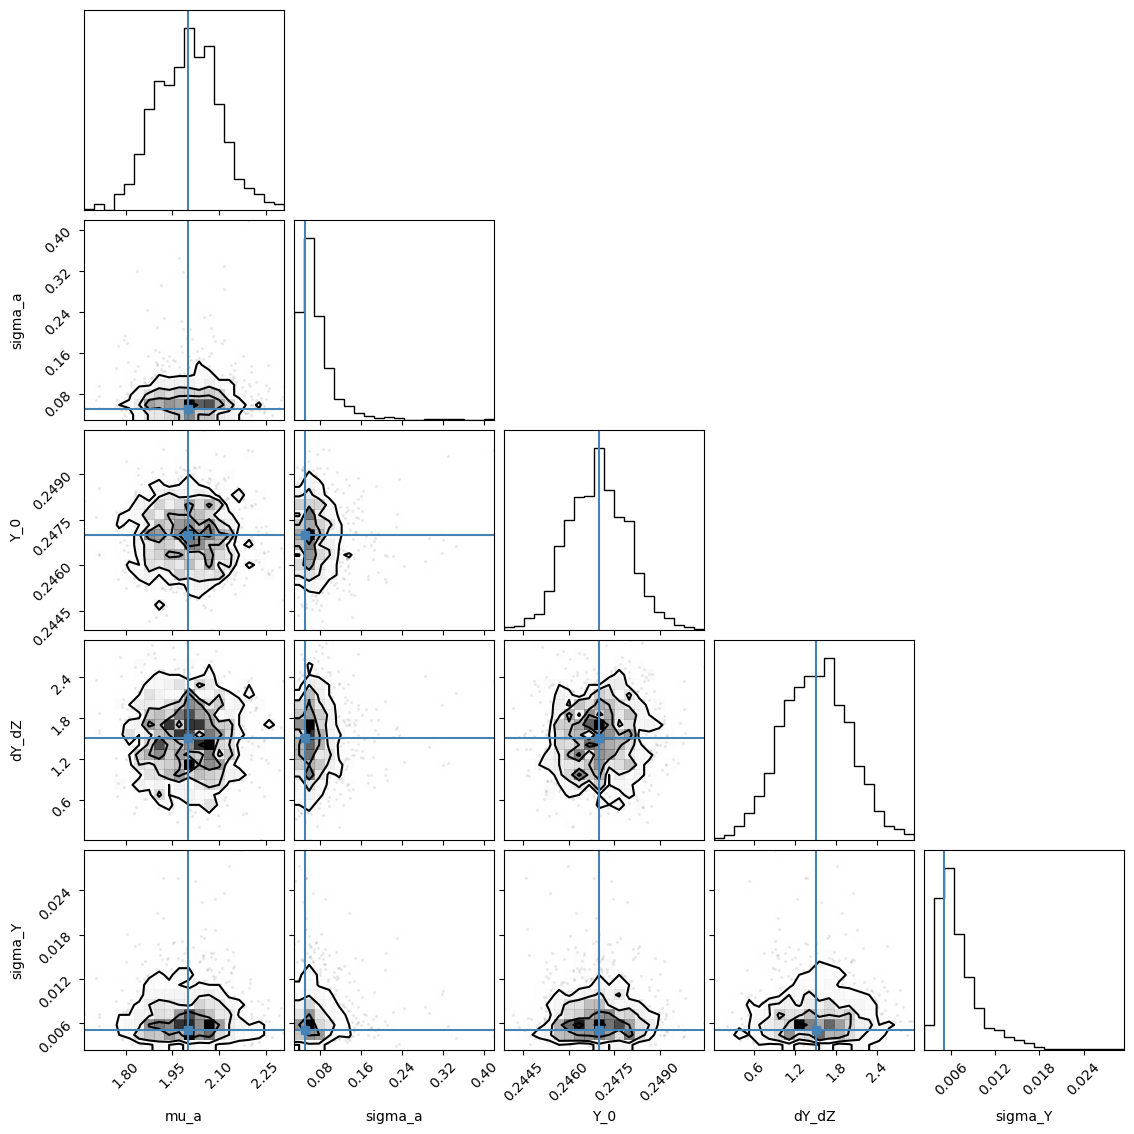

In [13]:
fig = corner(data, group="prior", var_names=hyperparam_names, truths=truths)

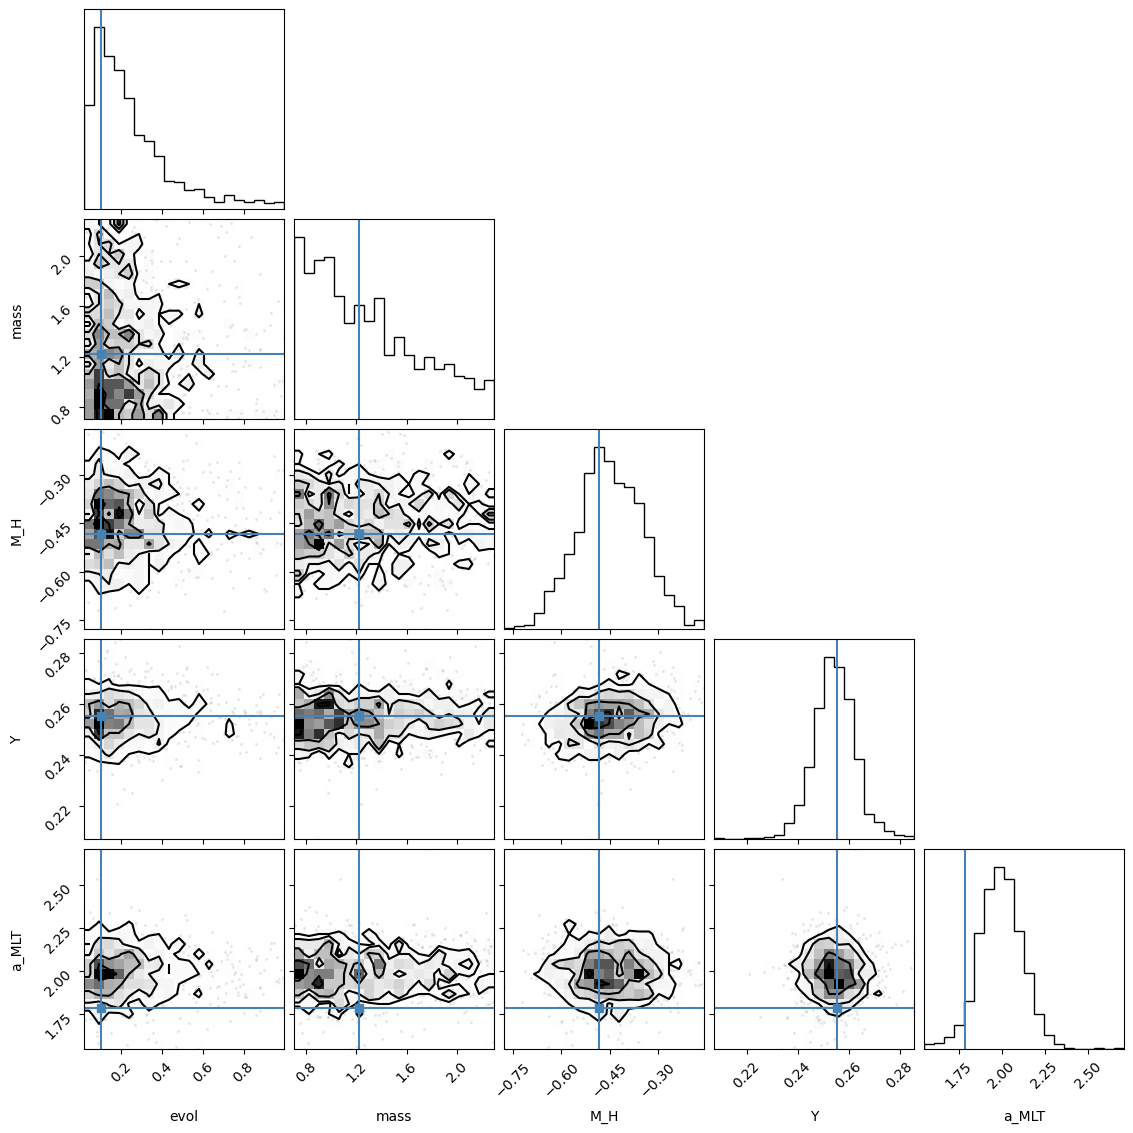

In [14]:
star = 0
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

Let's also look at some determinisitc parameters in the model.

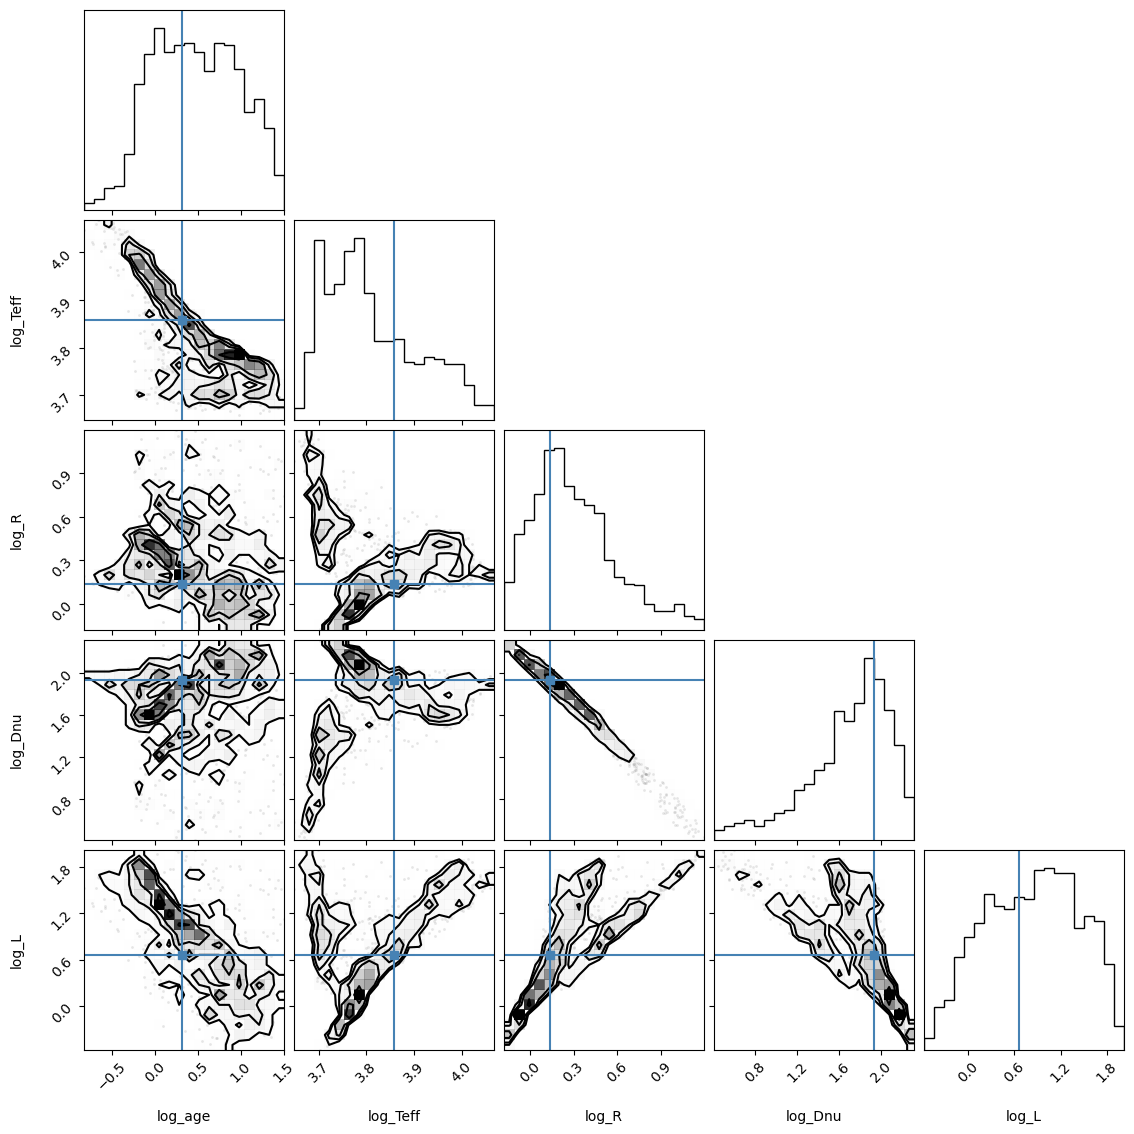

In [15]:
star = 0
var_names = ["log_age", "log_Teff", "log_R", "log_Dnu", "log_L"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

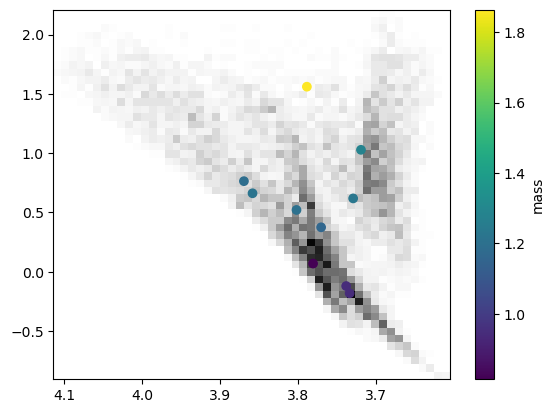

In [16]:
fig, ax = plt.subplots()

ax.hist2d(
    data.prior.log_Teff.values.ravel(), 
    data.prior.log_L.values.ravel(), 
    bins=50, 
    cmap="Grays"
)
s = ax.scatter(
    truths["log_Teff"], 
    truths["log_L"], 
    c=truths["mass"]
)
ax.invert_xaxis()
fig.colorbar(s, label="mass");

## Observation

Now we synthesize observable parameters for the model.

In [17]:
y = np.stack([obs[key] for key in observables], axis=-1)
diag = np.stack([obs[f"sigma_{key}"] for key in observables], axis=-1)**2
pprint(y)
pprint(diag)

array([[ 3.85789943,  0.66038287],
       [ 3.86471581,  0.75724435],
       [ 3.79705977,  1.5545435 ],
       [ 3.73745775, -0.1124095 ],
       [ 3.76583171,  0.37543735],
       [ 3.73567891, -0.18077204],
       [ 3.71212983,  1.02577937],
       [ 3.73464394,  0.61805433],
       [ 3.77918792,  0.07964213],
       [ 3.79383779,  0.51669067]])
array([[2.03708253e-05, 1.88611697e-05],
       [1.93623079e-05, 1.88611697e-05],
       [2.80810600e-05, 1.88611697e-05],
       [3.54155899e-05, 1.88611697e-05],
       [3.05452455e-05, 1.88611697e-05],
       [3.61492083e-05, 1.88611697e-05],
       [3.86499878e-05, 1.88611697e-05],
       [3.69059381e-05, 1.88611697e-05],
       [2.91261610e-05, 1.88611697e-05],
       [2.64109679e-05, 1.88611697e-05]])


## Sampling

Let's use the No U-Turn Sampler (NUTS) as our Markov Chain Monte Carlo (MCMC) sampling algorithm.

In [18]:
# sampler = NUTS(model, target_accept_prob=0.8, dense_mass=[("dY_dZ", "da_dM", "sigma_Y", "sigma_a")], init_strategy=init_to_median)
# sampler = NUTS(model, target_accept_prob=0.9, init_strategy=init_to_median, find_heuristic_step_size=True, max_tree_depth=11)
num_warmup, num_samples = 2000, 1000

sampler = NUTS(model, target_accept_prob=0.8, init_strategy=init_to_median, find_heuristic_step_size=True)
mcmc = MCMC(sampler, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

Let's run the MCMC and print a summary of results.

In [19]:
rng, key = random.split(rng)
start = time()
with jax.default_device(gpu):
    mcmc.run(key, obs=y, diag=diag)
elapsed_time = time() - start
mcmc.print_summary()

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             M_H[0]     -0.45      0.10     -0.46     -0.62     -0.29   5149.47      1.00
             M_H[1]     -0.60      0.10     -0.60     -0.76     -0.44   3708.39      1.00
             M_H[2]     -0.40      0.10     -0.40     -0.56     -0.23   6702.11      1.00
             M_H[3]      0.36      0.10      0.36      0.20      0.52   9200.17      1.00
             M_H[4]      0.37      0.10      0.37      0.19      0.52   6546.54      1.00
             M_H[5]      0.32      0.10      0.32      0.16      0.48  10253.80      1.00
             M_H[6]     -0.84      0.10     -0.84     -1.00     -0.68   9643.69      1.00
             M_H[7]      0.06      0.10      0.06     -0.10      0.23   6071.34      1.00
             M_H[8]     -0.79      0.10     -0.79     -0.96     -0.63   9188.20      1.00
             M_H[9]      0.15      0.09      0.15      0.01      0.30   6263.43      1.00
         

Looks pretty good. We want `r_hat` to be close to 1.0 (e.g. less than 1.1). We also want the number of divergances to be very small.

**Note:** The `MultiStarModel` takes longer than running `SingleStarModel` sequentially, but includes population-level priors. It's worth looking at other ways to do this faster.

Let's update our `InferenceData`.

In [20]:
posterior = mcmc.get_samples()

rng, key = random.split(rng)
posterior_predictive = Predictive(model, posterior_samples=posterior, parallel=True, return_sites=["y"])
y = posterior_predictive(key)["y"]

for i, key in enumerate(model.outputs):
    posterior[key] = y[..., i]

posterior = {k: v.reshape((num_chains, num_samples, -1)).squeeze() for k, v in posterior.items()}

In [21]:
sample_stats = mcmc.get_extra_fields(group_by_chain=True)

In [22]:
with jax.default_device(gpu):
    data += az.from_dict(posterior=posterior, sample_stats=sample_stats, coords=coords, dims=dims)
data

Inference data with groups:
	> posterior
	> sample_stats
	> prior

With `arviz`, we can create a summary of the data.

In [23]:
summary = az.summary(data, fmt="xarray")
summary

<xarray.Dataset>
Dimensions:           (star: 10, metric: 9)
Coordinates:
  * star              (star) int64 0 1 2 3 4 5 6 7 8 9
  * metric            (metric) <U9 'mean' 'sd' 'hdi_3%' ... 'ess_tail' 'r_hat'
Data variables: (12/24)
    M_H               (metric, star) float64 -0.4547 -0.5997 ... 1.001 1.0
    Y                 (metric, star) float64 0.255 0.2526 0.2561 ... 1.001 1.001
    Y_0               (metric) float64 0.247 0.001009 0.2451 ... 6.395e+03 1.001
    Y_decentered      (metric, star) float64 0.01895 -0.008488 ... 1.001 1.001
    a_MLT             (metric, star) float64 2.018 2.017 2.021 ... 1.001 1.001
    a_decentered      (metric, star) float64 0.01389 0.01205 ... 1.003 1.001
    ...                ...
    log_Teff          (metric, star) float64 3.858 3.865 3.797 ... 1.001 1.001
    log_R             (metric, star) float64 0.1369 0.1709 0.7063 ... 1.0 1.0
    log_Dnu           (metric, star) float64 1.939 1.881 1.199 ... 1.001 1.001
    log_L             (metric, star) float64 0.6601 0.7572 1.554 ... 1.002 1.0
    log_g             (metric, star) float64 4.254 4.175 3.295 ... 1.001 1.001
    log_numax         (metric, star) float64 3.258 3.175 2.33 ... 1.001 1.001

In [24]:
summary_nan = summary.where(summary.sel(metric="r_hat") < 1.1).to_array()
summary_nan

<xarray.DataArray (variable: 24, metric: 9, star: 10)>
array([[[-4.54701185e-01, -5.99658370e-01, -3.98862273e-01, ...,
          6.08010367e-02, -7.90921807e-01,  1.52341709e-01],
        [ 9.85365659e-02,  1.00650549e-01,  9.99127775e-02, ...,
          1.00113958e-01,  9.90041718e-02,  9.02107060e-02],
        [-6.41578376e-01, -7.83471048e-01, -5.85061014e-01, ...,
         -1.28000170e-01, -9.81827259e-01, -2.07774621e-02],
        ...,
        [ 5.20072157e+03,  3.79258618e+03,  6.72502071e+03, ...,
          6.13921978e+03,  9.20996176e+03,  6.35816324e+03],
        [ 5.64536057e+03,  6.23608434e+03,  5.81774769e+03, ...,
          5.90888343e+03,  7.18747498e+03,  6.92277725e+03],
        [ 1.00074587e+00,  1.00064299e+00,  1.00103594e+00, ...,
          1.00149914e+00,  1.00104747e+00,  1.00038071e+00]],

       [[ 2.55034685e-01,  2.52575099e-01,  2.56054580e-01, ...,
          2.71685392e-01,  2.50095695e-01,  2.77795762e-01],
        [ 8.40480719e-03,  8.08760803e-03,  8.52131937e-03, ...,
          1.18312733e-02,  7.80747877e-03,  1.29935676e-02],
        [ 2.39090830e-01,  2.37814248e-01,  2.39909947e-01, ...,
          2.50712812e-01,  2.34966725e-01,  2.53782779e-01],
...
        [ 6.31405199e+03,  5.27463502e+03,  9.73782535e+03, ...,
          7.68422213e+03,  6.37882291e+03,  4.94359163e+03],
        [ 6.20631756e+03,  6.85263871e+03,  7.59682957e+03, ...,
          8.48708890e+03,  6.23401910e+03,  6.53989993e+03],
        [ 1.00094202e+00,  1.00039785e+00,  9.99951882e-01, ...,
          1.00141511e+00,  1.00135700e+00,  1.00111102e+00]],

       [[ 3.25773621e+00,  3.17492032e+00,  2.32963872e+00, ...,
          2.85905337e+00,  3.37514091e+00,  3.17829943e+00],
        [ 2.81250589e-02,  2.73405388e-02,  2.14552470e-02, ...,
          2.36386061e-02,  4.06931490e-02,  2.97382344e-02],
        [ 3.20449877e+00,  3.12364745e+00,  2.28861213e+00, ...,
          2.81556797e+00,  3.30040097e+00,  3.12646961e+00],
        ...,
        [ 6.14098253e+03,  5.03441206e+03,  9.05267674e+03, ...,
          7.23984952e+03,  6.25572577e+03,  4.69720660e+03],
        [ 6.13615200e+03,  7.39843722e+03,  7.55707985e+03, ...,
          8.33528827e+03,  6.12407093e+03,  6.39795239e+03],
        [ 1.00110773e+00,  1.00021150e+00,  1.00009201e+00, ...,
          1.00160553e+00,  1.00123682e+00,  1.00070198e+00]]])
Coordinates:
  * star      (star) int64 0 1 2 3 4 5 6 7 8 9
  * metric    (metric) <U9 'mean' 'sd' 'hdi_3%' ... 'ess_tail' 'r_hat'
  * variable  (variable) object 'M_H' 'Y' 'Y_0' ... 'log_L' 'log_g' 'log_numax'

In [25]:
summary_stacked = summary_nan.stack(x=["variable", "metric", "star"])
null_coords = summary_stacked[summary_stacked.isnull()].coords
bad_stars = set(null_coords["star"].values)
print(bad_stars)

set()


In [26]:
efficiency = summary.sel(metric="ess_bulk") / elapsed_time

In [28]:
values = []
for value in efficiency.values():
    values.append(np.atleast_1d(value))

eff = np.concatenate(values)

Text(0, 0.5, 'Count')

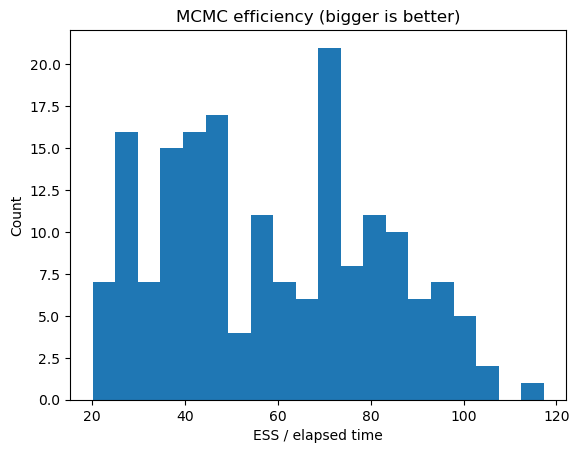

In [29]:
fig, ax = plt.subplots()

ax.hist(eff, bins=20)
ax.set_title("MCMC efficiency (bigger is better)")
ax.set_xlabel("ESS / elapsed time")
ax.set_ylabel("Count")

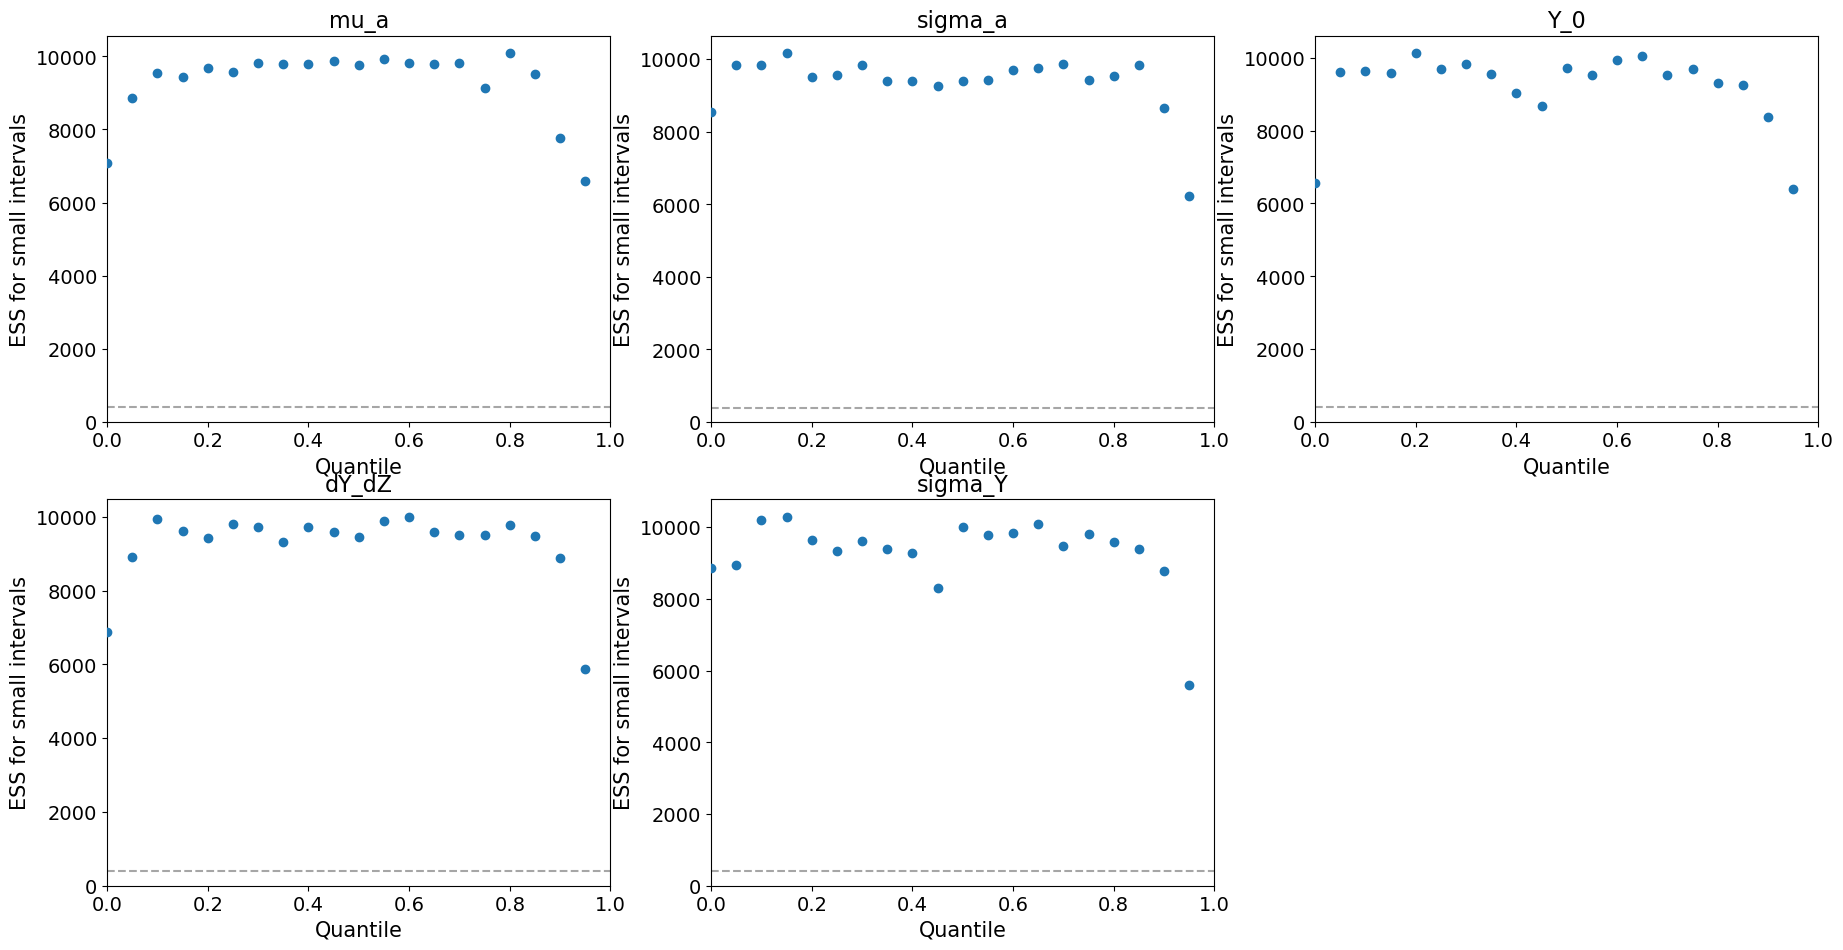

In [30]:
az.plot_ess(data, var_names=hyperparam_names);

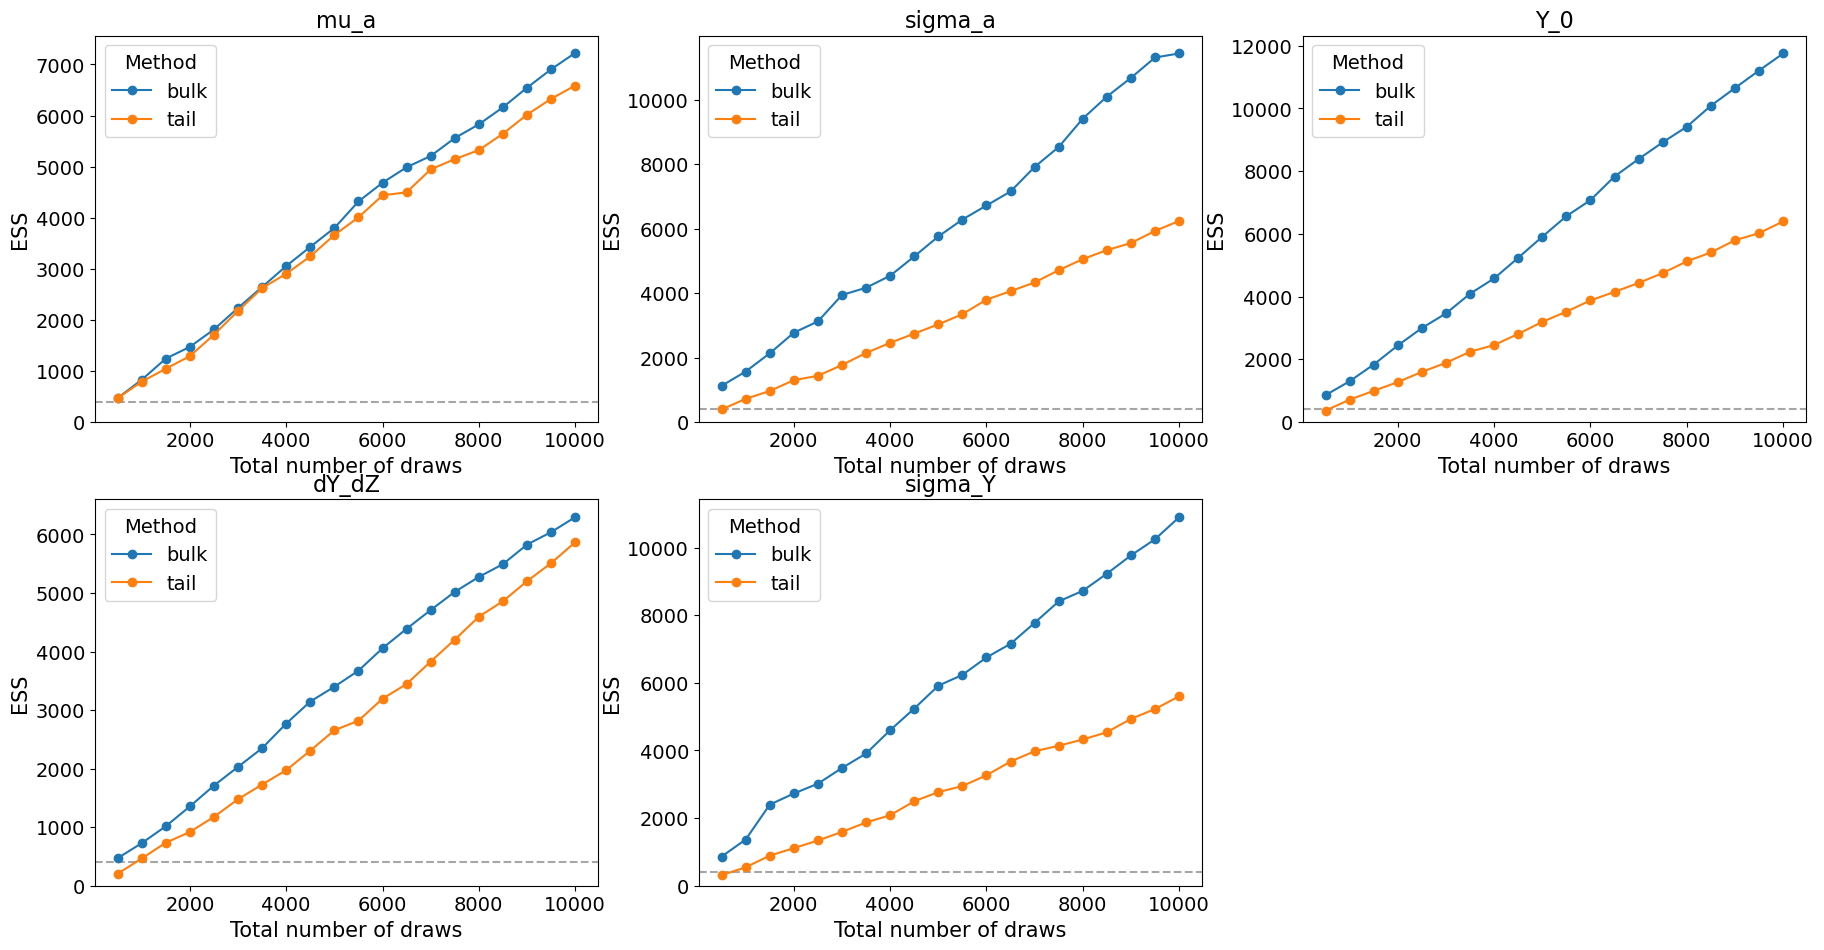

In [31]:
az.plot_ess(data, kind="evolution", var_names=hyperparam_names);

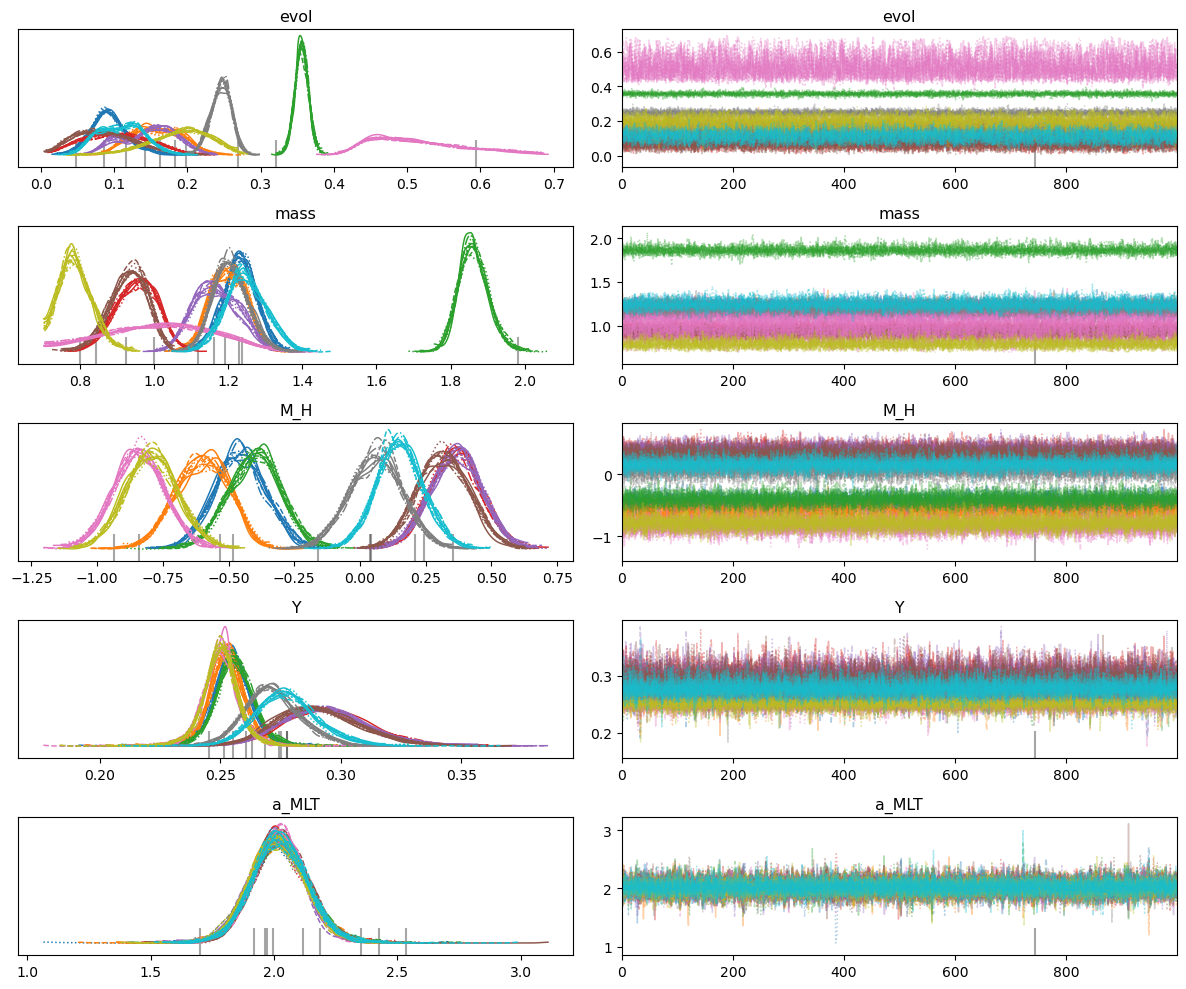

In [32]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
az.plot_trace(data, var_names=var_names, coords=dict(star=range(min(num_stars, 10))))
plt.tight_layout()

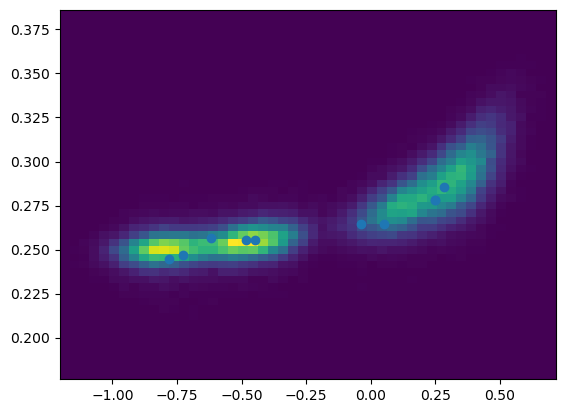

In [33]:
mh = data.posterior.M_H.values.flatten()
y = data.posterior.Y.values.flatten()
plt.hist2d(mh, y, bins=50)
plt.scatter(truths["M_H"], truths["Y"]);

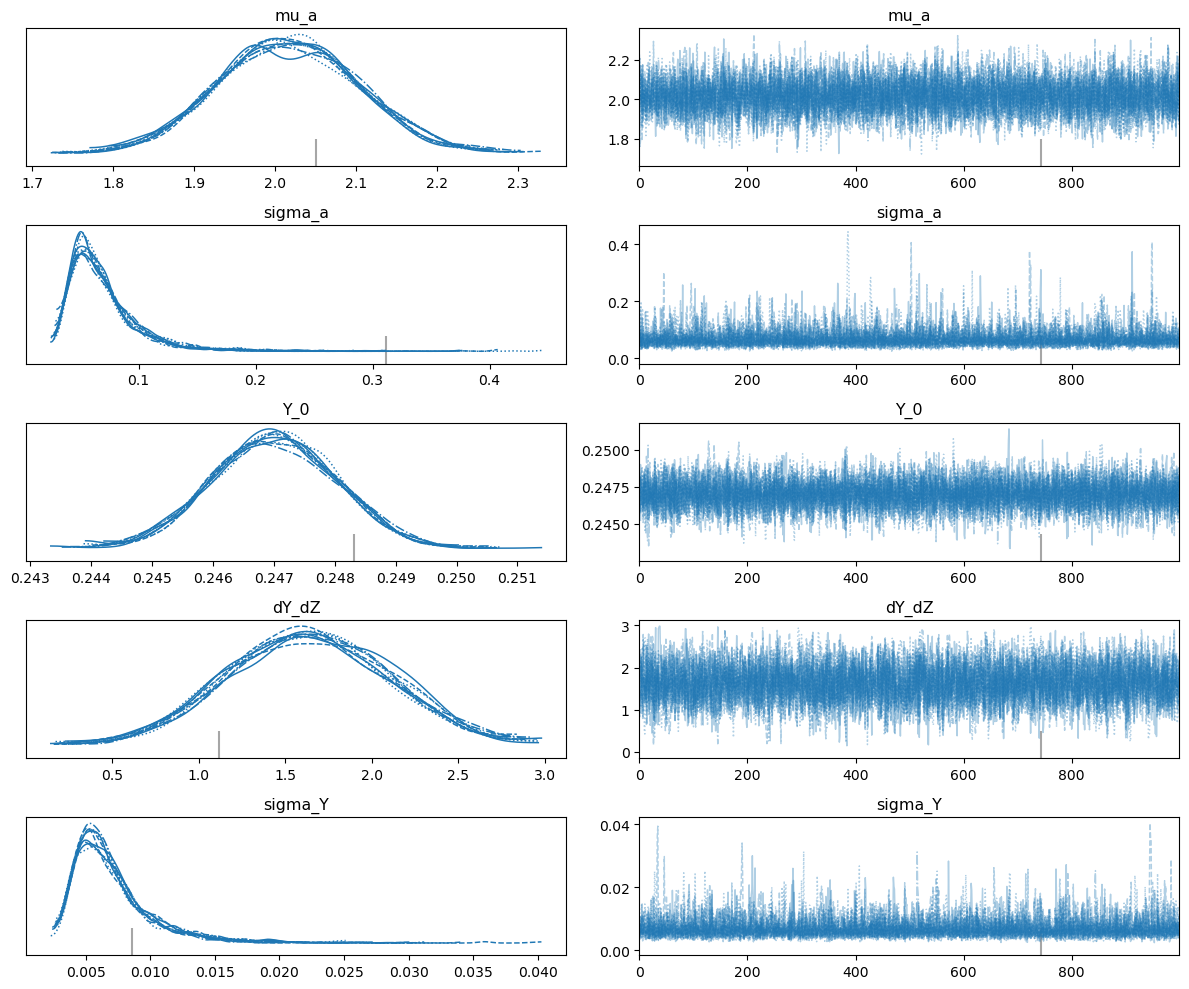

In [34]:
az.plot_trace(data, var_names=hyperparam_names)
plt.tight_layout()

## Posterior Predictive

Let's check the joint posterior distributions and compare with the truth values.

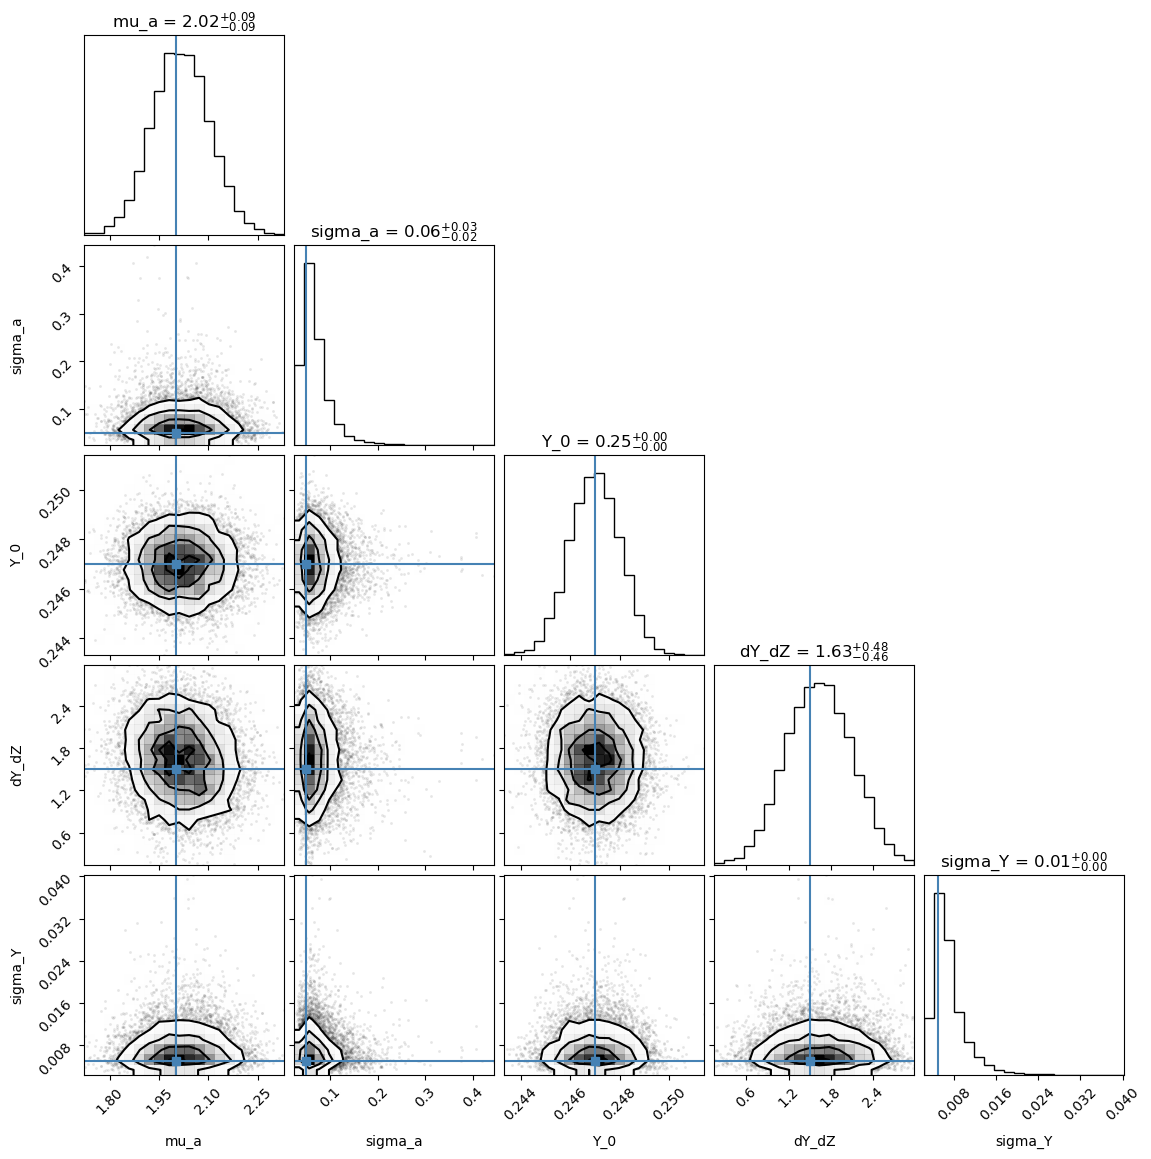

In [37]:
fig = corner(data, group="posterior", var_names=hyperparam_names, truths=truths, show_titles=True)

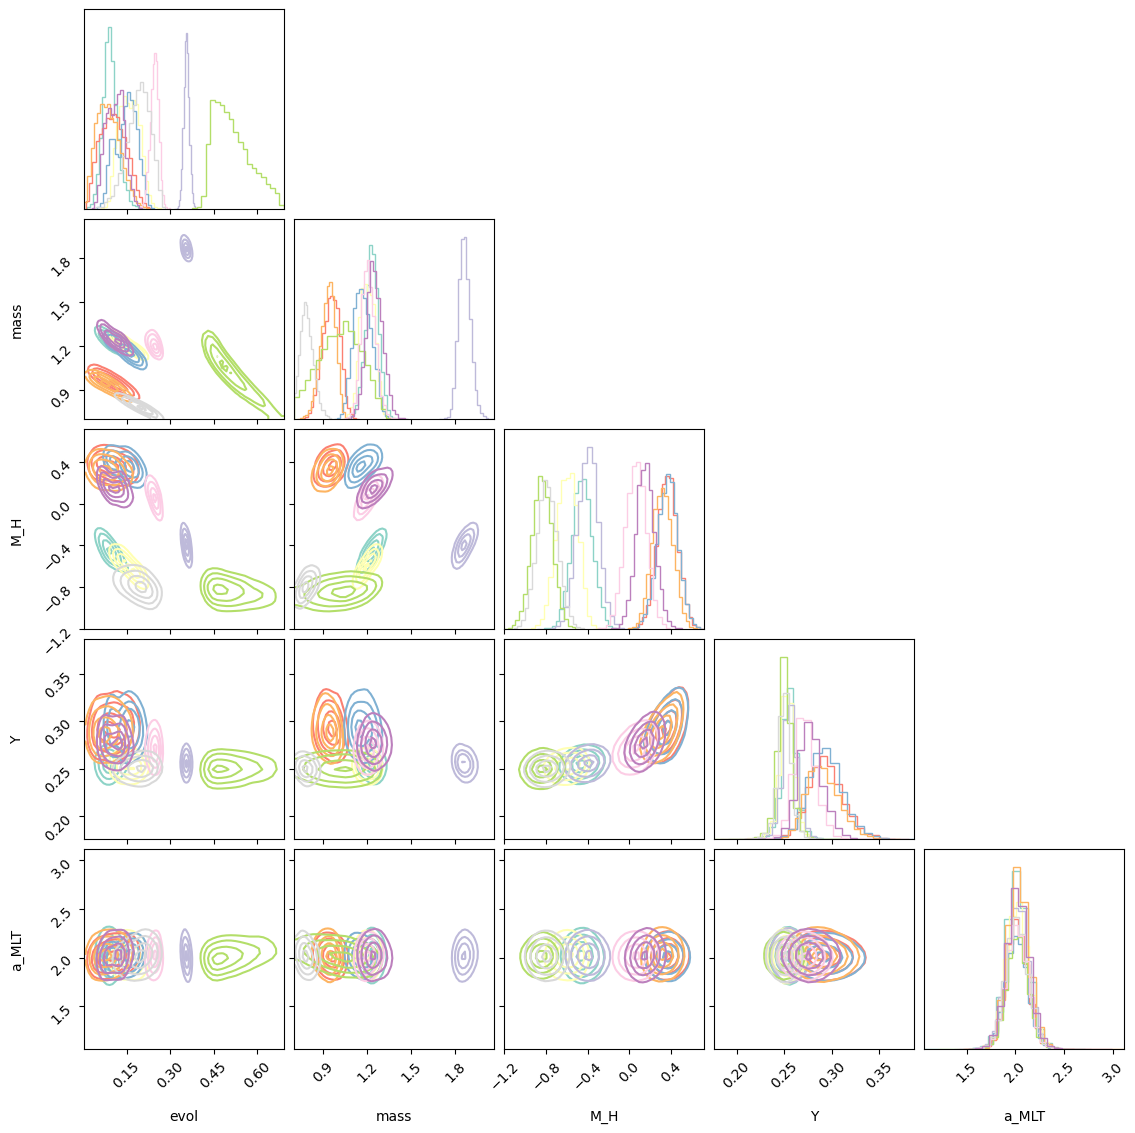

In [38]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
max_stars = num_stars
cmap = colormaps["Set3"]
fig = None
for star in range(num_stars):
    coords_ = {"star": star}
    color = cmap(star%cmap.N)  # loop colors
    fig = corner(data, var_names=var_names, coords=coords_, color=color, fig=fig,
                 plot_datapoints=False, plot_density=False, smooth=1.0)

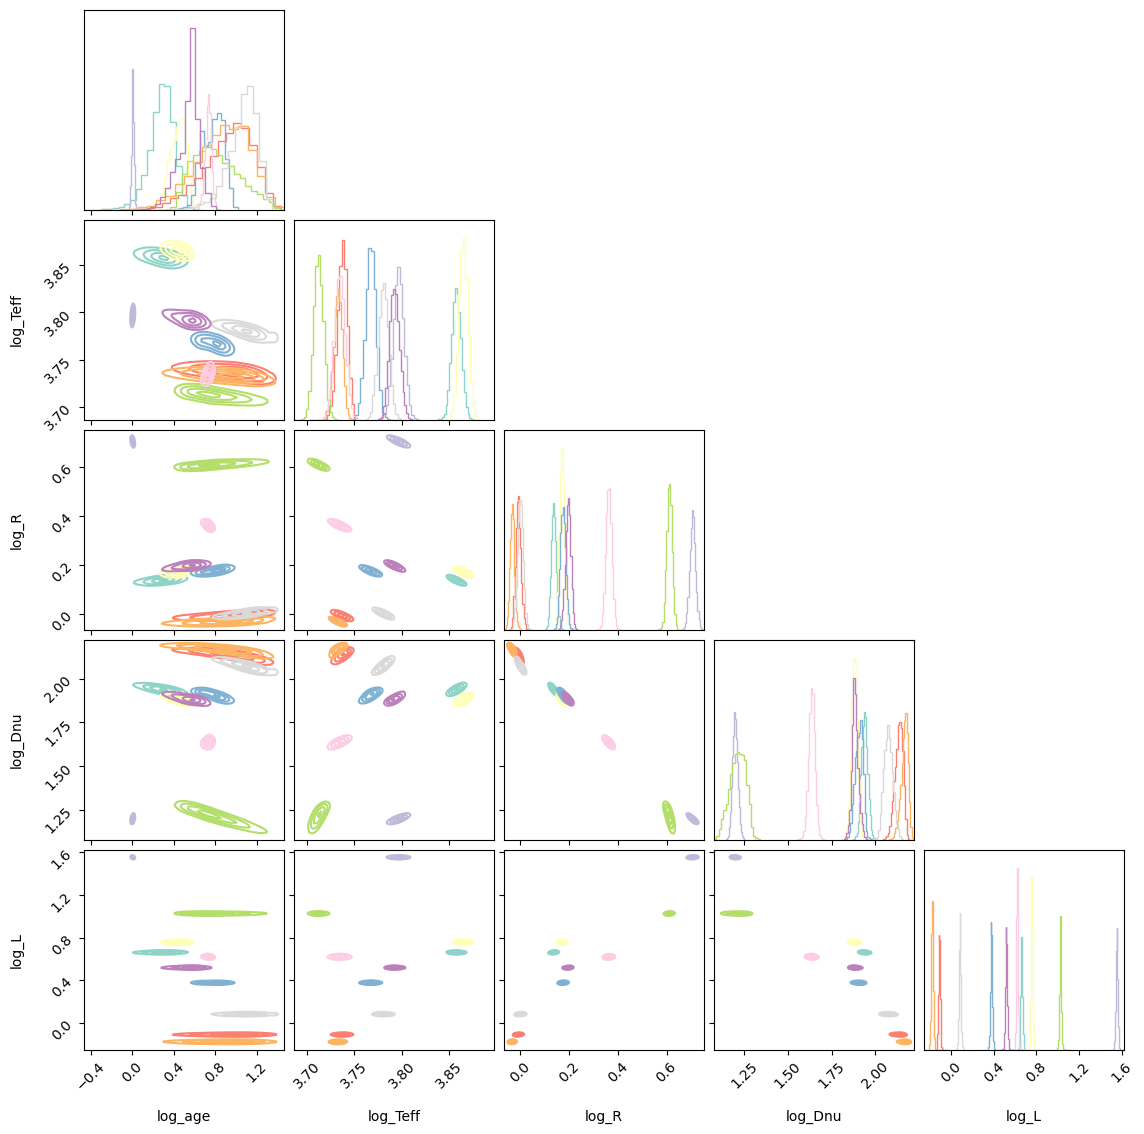

In [39]:
var_names = ["log_age", "log_Teff", "log_R", "log_Dnu", "log_L"]
max_stars = num_stars
cmap = colormaps["Set3"]
fig = None
for star in range(max_stars):
    coords_ = {"star": star}
    color = cmap(star%cmap.N)  # loop colors
    fig = corner(data, var_names=var_names, coords=coords_, color=color, fig=fig,
                 plot_datapoints=False, plot_density=False, smooth=1.0)

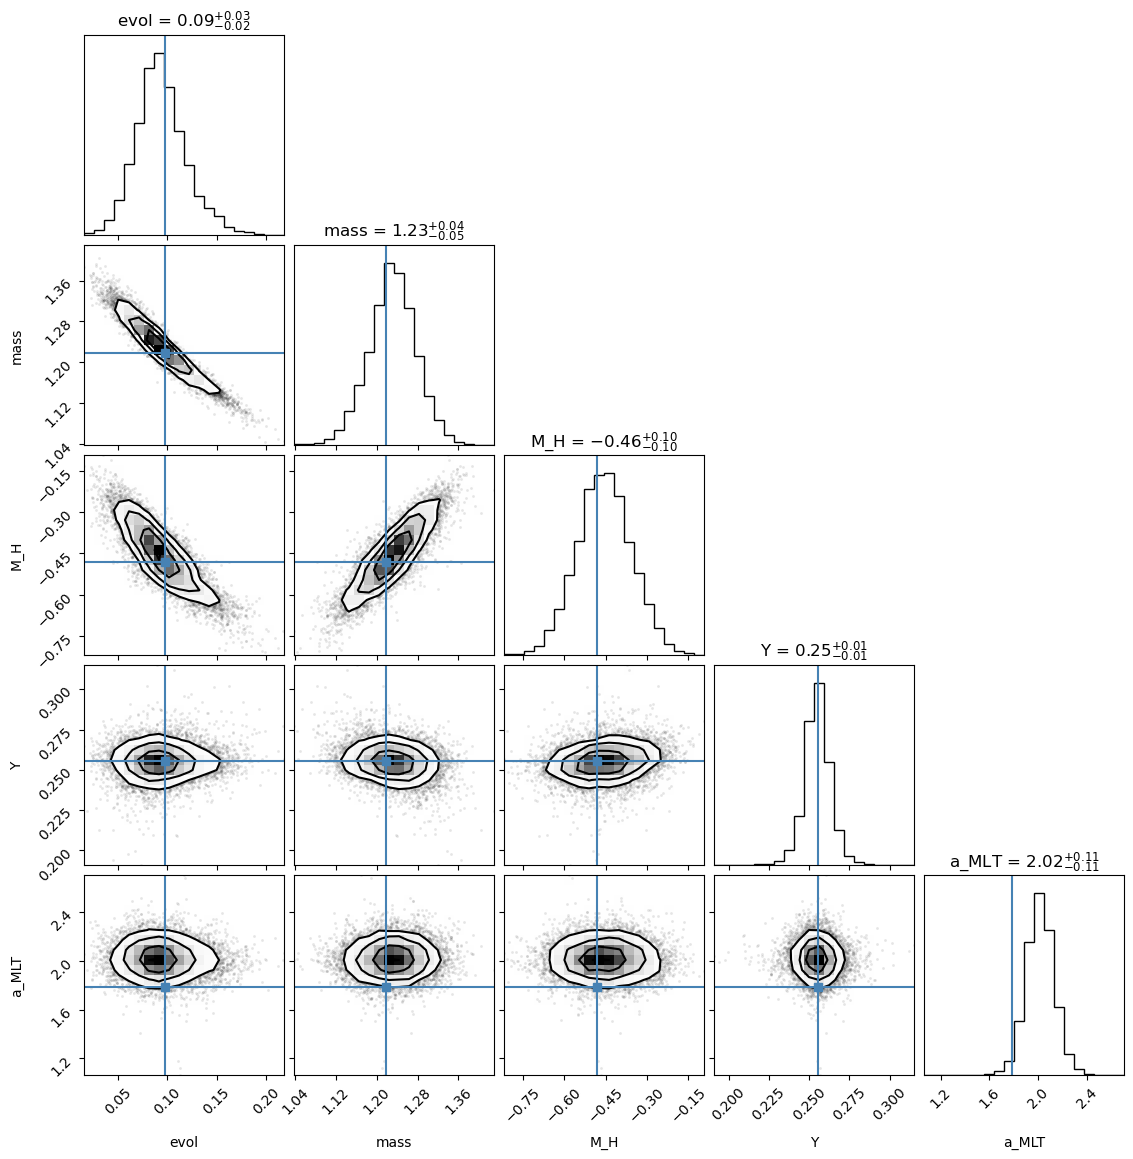

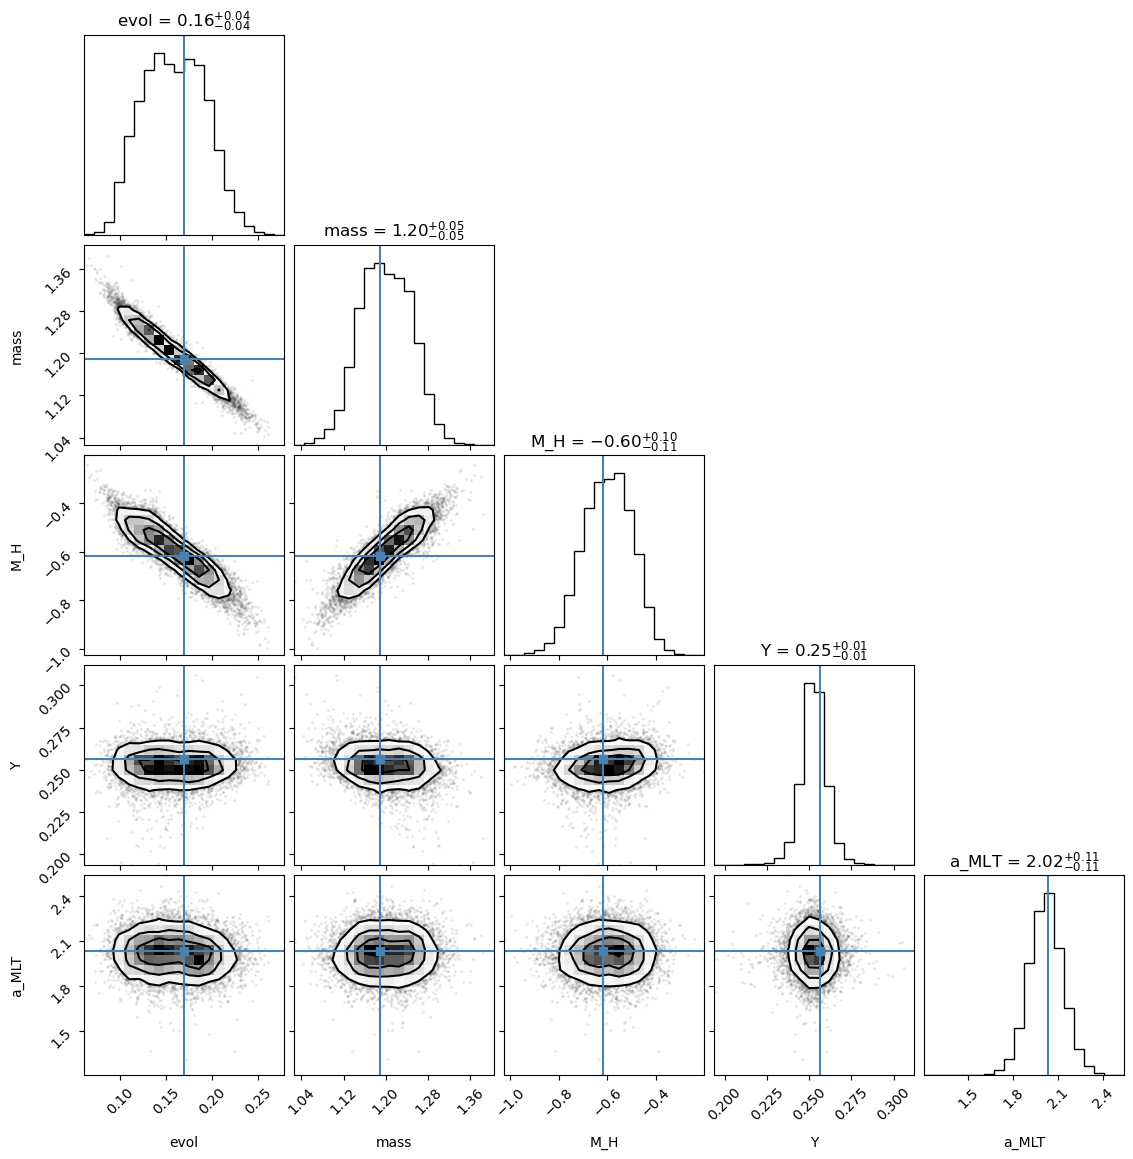

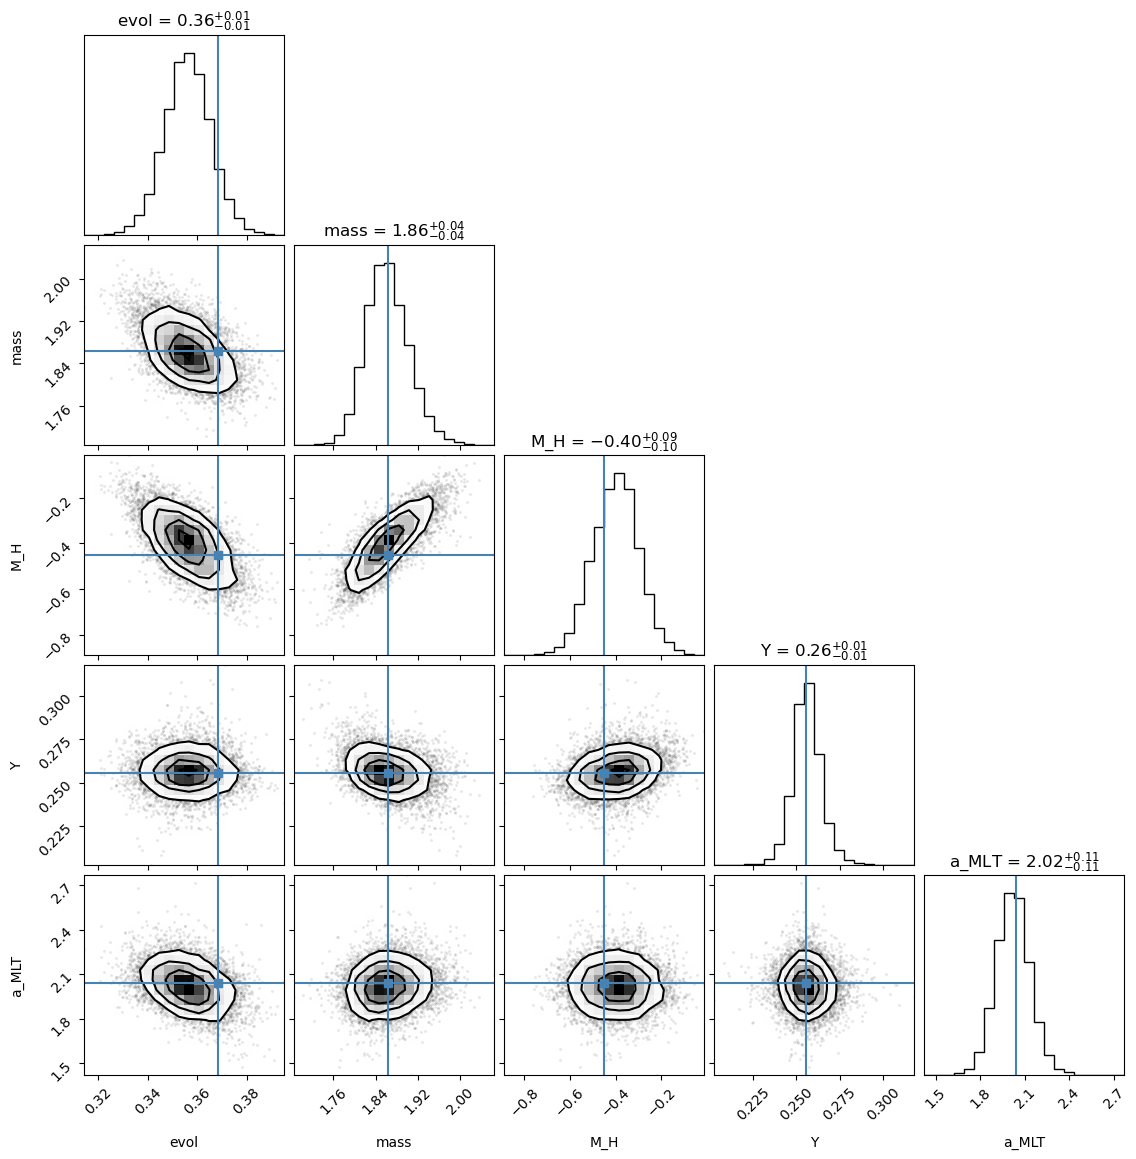

In [40]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_, show_titles=True)

What do we predict for some deterministics?

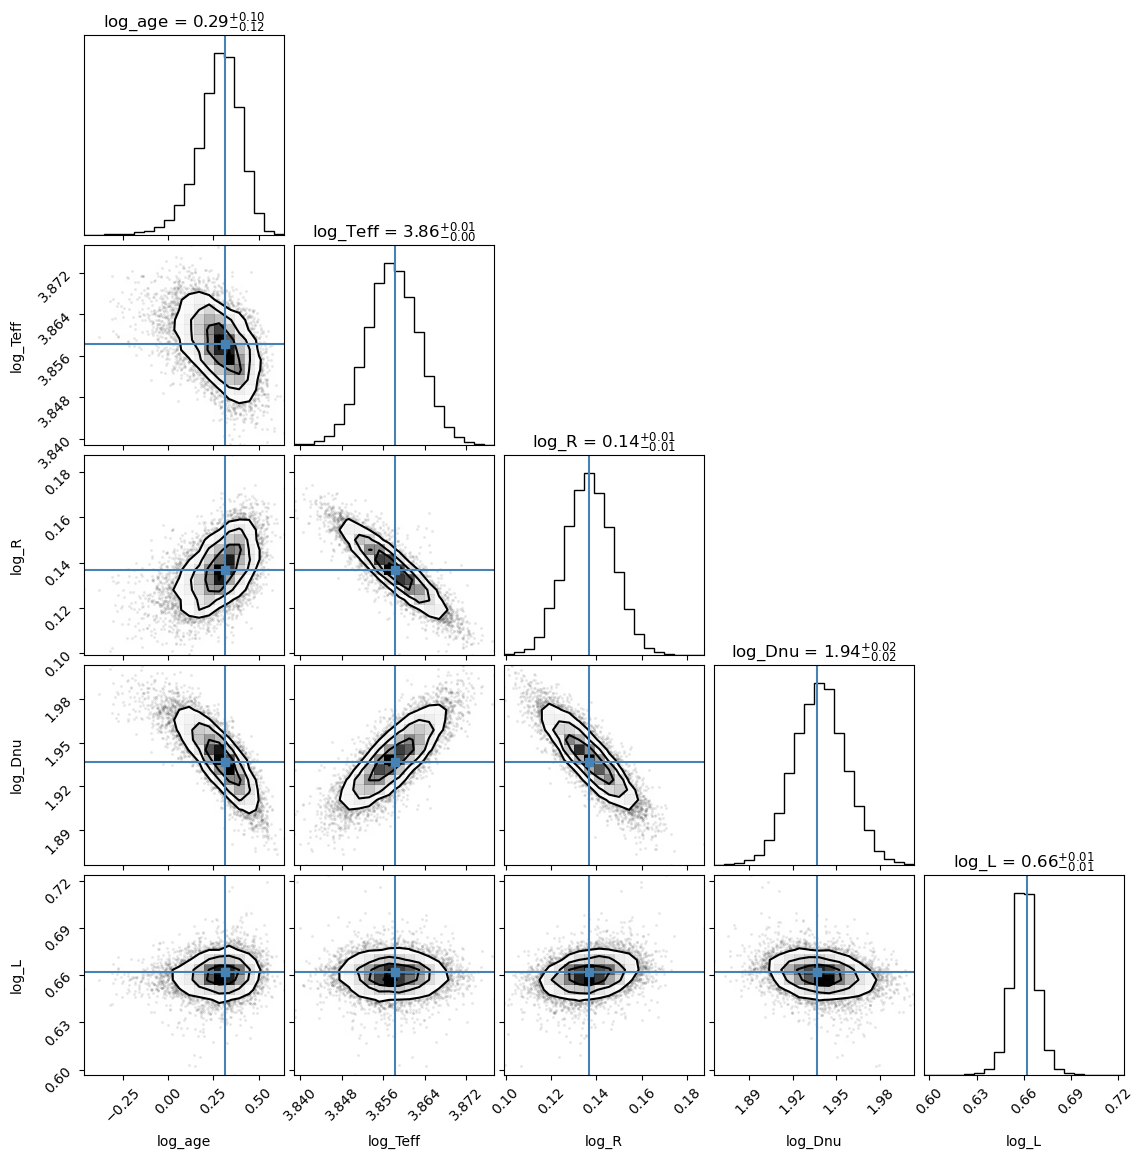

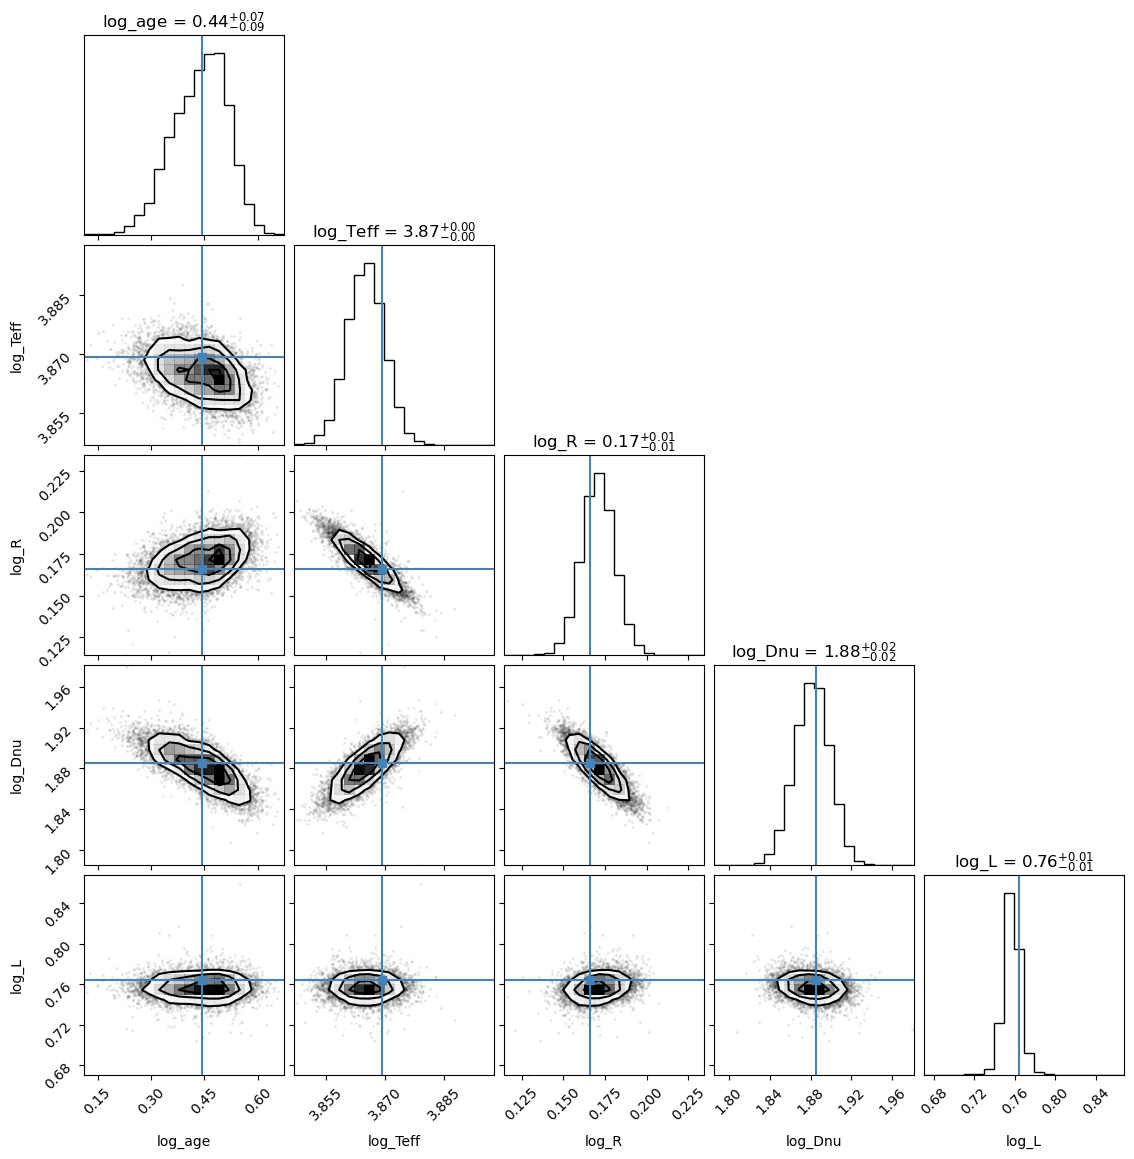

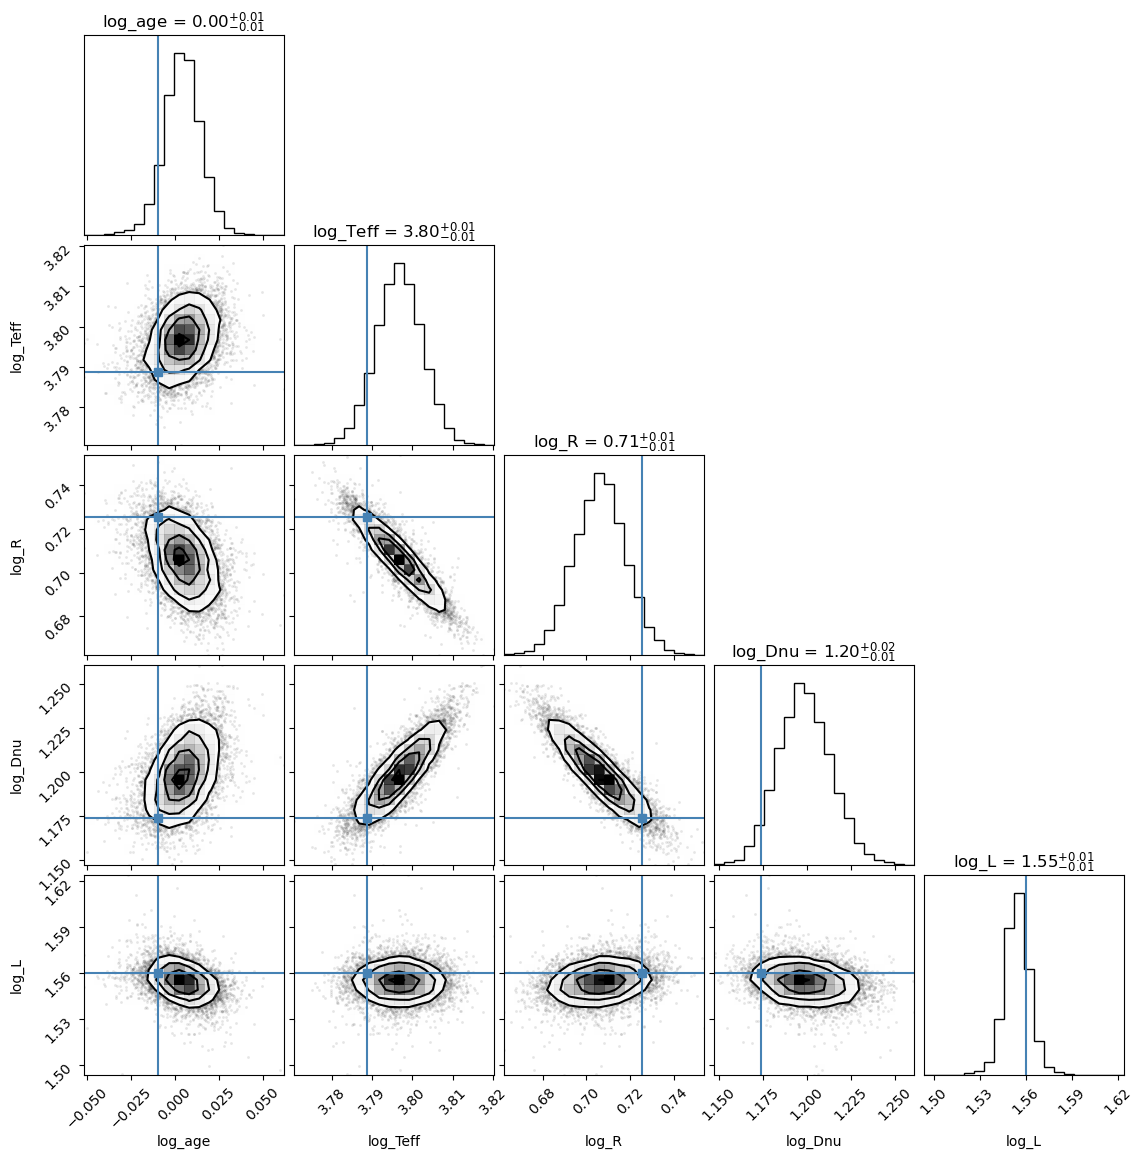

In [42]:
var_names = ["log_age", "log_Teff", "log_R", "log_Dnu", "log_L"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, var_names=var_names, truths=truths_, coords=coords_, show_titles=True)

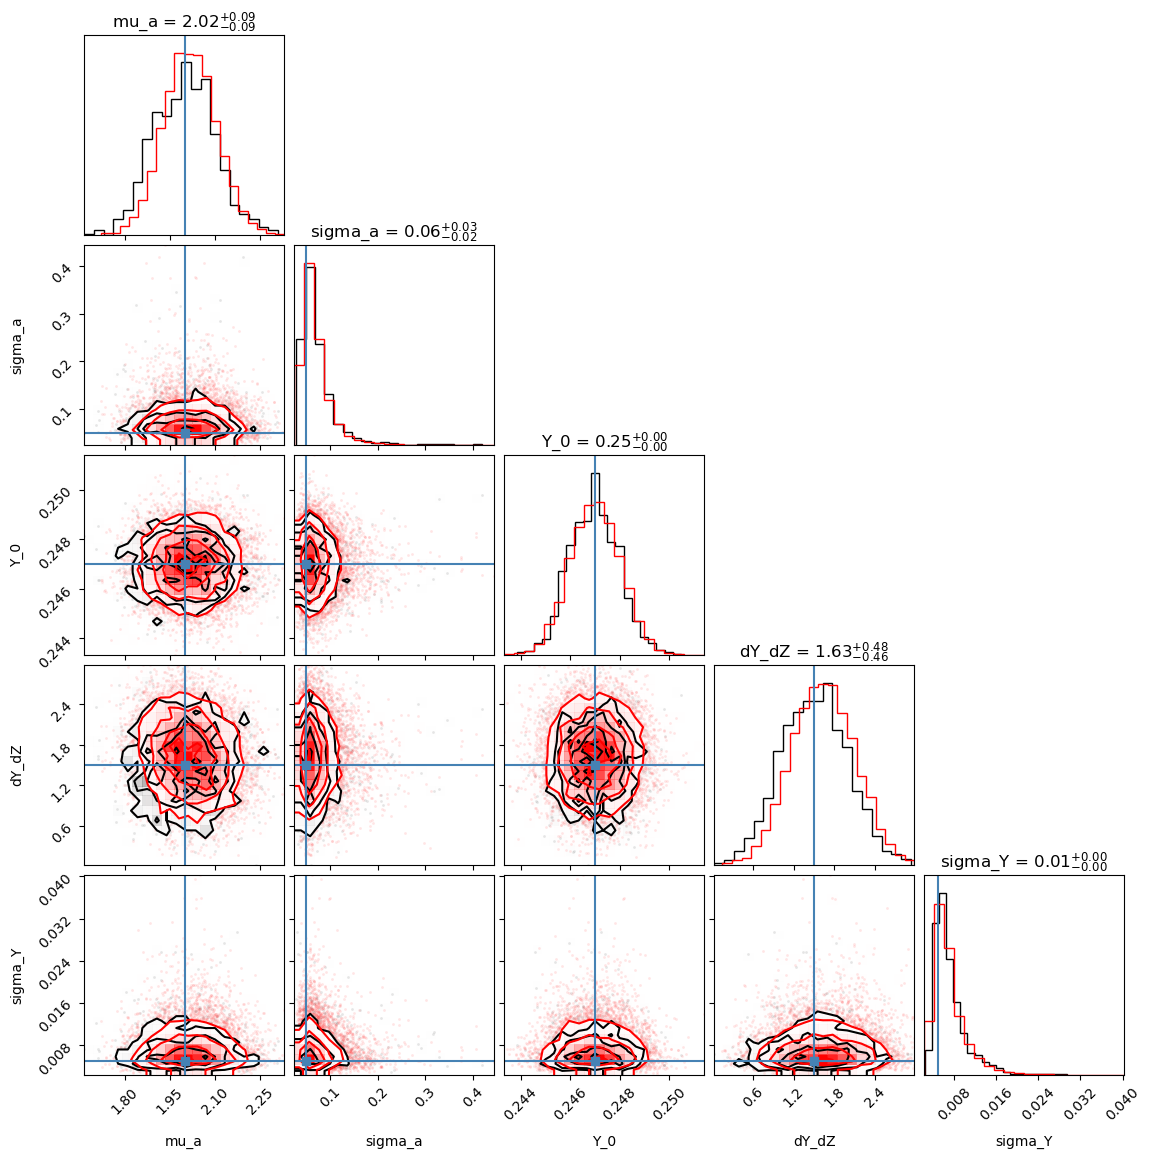

In [43]:
# limits = [(1.5, 2.5), (0.0, 0.4), (0.244, 0.250), (0.0, 3.0), (0.0, 0.04)]
limits = None
hist_kwargs = dict(density=True)
fig = corner(data, group="prior", var_names=hyperparam_names, range=limits, hist_kwargs=hist_kwargs)

hist_kwargs["color"] = "r"
fig = corner(data, var_names=hyperparam_names, range=limits, hist_kwargs=hist_kwargs,
             color="r", truths=truths, show_titles=True, fig=fig)


Let's look at the fractional error between each posterior sample and the truth. This gives us an idea of the precision and accuracy of our results. Don't expect anything impressive, we are marginalising over `Y` and `a_MLT` after all.

In [44]:
error = truths - data.posterior
az.summary(error)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
M_H[0]       -0.027  0.099  -0.210    0.160      0.001    0.001    5201.0   
M_H[1]       -0.017  0.101  -0.197    0.167      0.002    0.001    3793.0   
M_H[2]       -0.050  0.100  -0.237    0.136      0.001    0.001    6725.0   
M_H[3]       -0.113  0.097  -0.294    0.069      0.001    0.001    9444.0   
M_H[4]       -0.083  0.099  -0.265    0.105      0.001    0.001    6571.0   
...             ...    ...     ...      ...        ...      ...       ...   
log_numax[5]  0.010  0.032  -0.043    0.072      0.000    0.000    5832.0   
log_numax[6]  0.128  0.075   0.003    0.271      0.001    0.001    4104.0   
log_numax[7] -0.010  0.024  -0.055    0.034      0.000    0.000    7240.0   
log_numax[8]  0.024  0.041  -0.051    0.098      0.001    0.000    6256.0   
log_numax[9]  0.013  0.030  -0.051    0.065      0.000    0.000    4697.0   

              ess_tail  r_hat  
M_H[0]          5645.0    1.0  
M_H[1]          6236.0    1.0  
M_H[2]          5818.0    1.0  
M_H[3]          7469.0    1.0  
M_H[4]          7425.0    1.0  
...                ...    ...  
log_numax[5]    5943.0    1.0  
log_numax[6]    3809.0    1.0  
log_numax[7]    8335.0    1.0  
log_numax[8]    6124.0    1.0  
log_numax[9]    6398.0    1.0  

[135 rows x 9 columns]

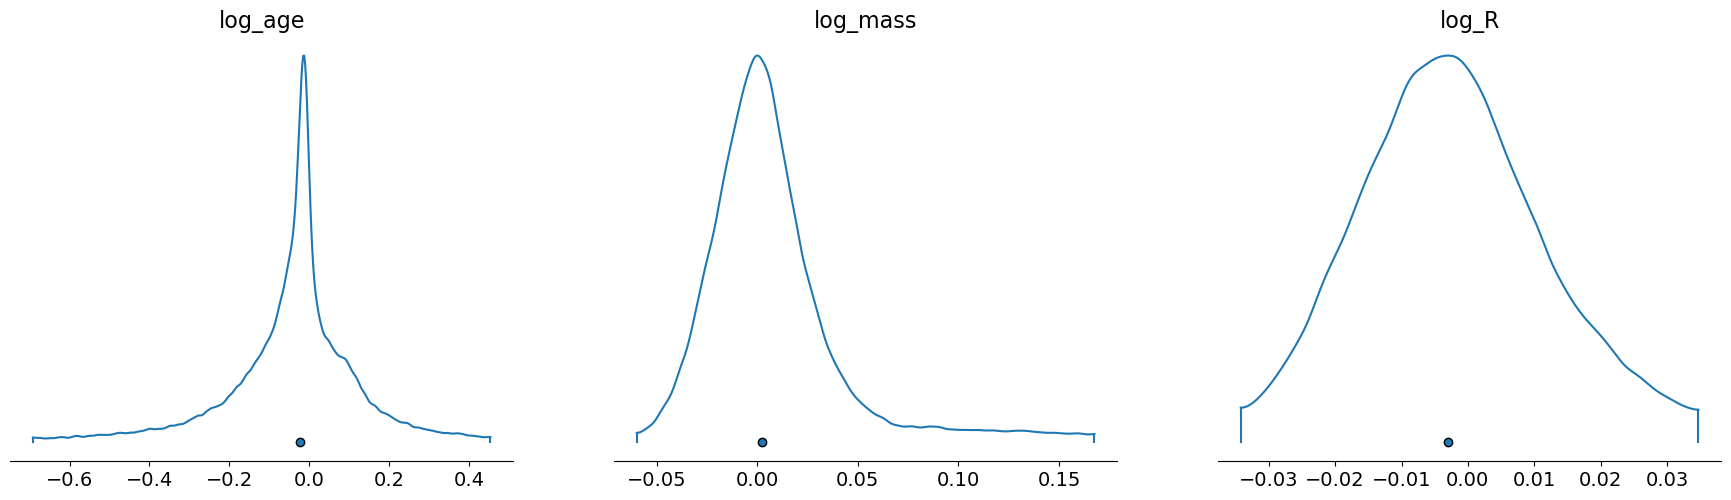

In [47]:
var_names = ["log_age", "log_mass", "log_R"]
az.plot_density(error, var_names=var_names, combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

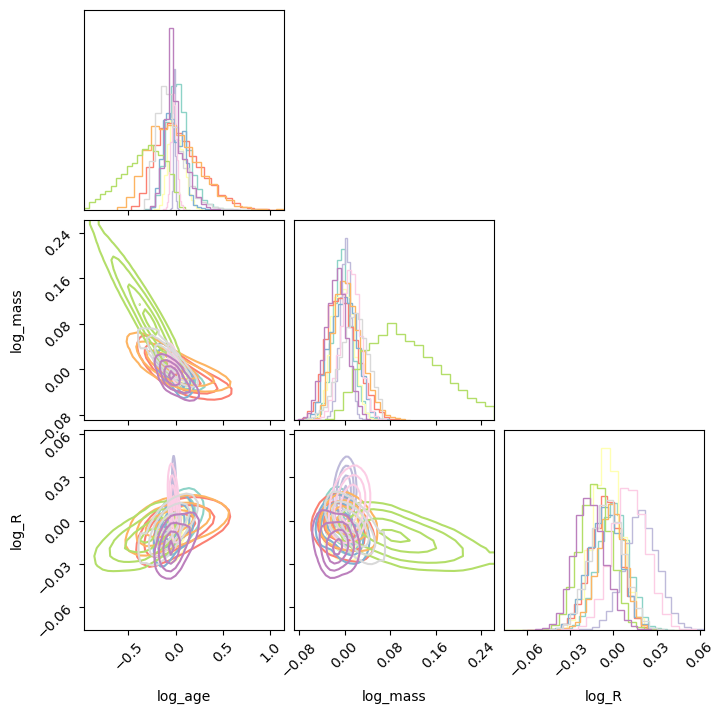

In [48]:
max_stars = num_stars
cmap = colormaps["Set3"]
fig = None
for star in range(max_stars):
    coords_ = {"star": star}
    color = cmap(star%cmap.N)  # loop colors
    fig = corner(error, var_names=var_names, coords=coords_, color=color, fig=fig,
                 plot_datapoints=False, plot_density=False, smooth=1.0)